In [9]:
import SimDAT2D.SimDAT2D as sim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IsoDAT2D.IsoDAT2D as iso
from PIL import Image
import pyFAI, fabio
from pyFAI.gui import jupyter
import pyFAI
import os
import matplotlib.pyplot as plt
from tifffile import imread
from SimDAT2D import masking
import pyFAI.azimuthalIntegrator as AI
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [10]:
def create_mask_for_tiff(tiff_path, width):
    """
    This function creates a mask for the azimuthal integrator from a TIFF file.
    
    Parameters:
        tiff_path (str): Path to the TIFF file
        width (int): The width of the line of interest
    """
    # Import tiff file
    from tifffile import imread
    image = imread(tiff_path)
    
    # Get the center point (assuming square image)
    center = image.shape[0] // 2
    
    # Create the mask
    mask = np.ones_like(image)
    mask[center-width:center+width, center:] = 0
    
    # Display the mask
    plt.figure(figsize=(5, 5))
    plt.imshow(mask, cmap='viridis')
    plt.title("Mask")
    plt.show()
    
    return mask

In [11]:
def fill_nan_with_neighbor_mean_circle(image, radius=None, center=None):
    """
    Fill NaN values with the mean of neighboring non-NaN pixels, but only within
    a circular region defined by radius and center
    
    Parameters:
    image: 2D numpy array
    radius: radius of circle (default: min(height,width)/2)
    center: (y,x) coordinates of circle center (default: image center)
    """
    # Create a copy of the image
    filled_image = np.copy(image)
    
    # Set defaults if not provided
    if center is None:
        center = (image.shape[0]//2, image.shape[1]//2)  # (y, x)
    if radius is None:
        radius = min(image.shape[0], image.shape[1])//2
        
    # Create a circular mask
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    dist_from_center = np.sqrt((y - center[0])**2 + (x - center[1])**2)
    circle_mask = dist_from_center <= radius
    
    # Find NaN pixels
    nan_y, nan_x = np.where(np.isnan(filled_image))
    
    # Loop through each NaN pixel
    for y, x in zip(nan_y, nan_x):
        # Check if this pixel is within the circle
        if circle_mask[y, x]:
            # Define a window around the NaN pixel (5x5 window)
            y_start = max(0, y - 2)
            y_end = min(image.shape[0], y + 3)
            x_start = max(0, x - 2)
            x_end = min(image.shape[1], x + 3)
            
            # Extract the window
            window = filled_image[y_start:y_end, x_start:x_end]
            
            # Calculate mean of non-NaN values in the window
            mean_value = np.nanmean(window)
            
            # Replace NaN with the calculated mean
            filled_image[y, x] = mean_value
            
    # Set all pixels outside circle to NaN
    filled_image[~circle_mask] = np.nan
    
    return filled_image

In [12]:
def apply_polarization(image, distance, center=None, polarization_factor=0.99):
    """
    Apply polarization correction to 2D diffraction image.
    
    Parameters:
        image (2D array): Raw diffraction image
        distance (float): Sample-to-detector distance in meters
        center (tuple): (x,y) beam center coordinates. If None, assumes center of image
        polarization_factor (float): Polarization factor, typically 0.99 for synchrotron
        
    Returns:
        2D array: Polarization-corrected image
    """
    import numpy as np
    
    # Get image dimensions and center if not provided
    ny, nx = image.shape
    if center is None:
        center = (nx//2, ny//2)
    
    # Create coordinate grid relative to beam center
    y, x = np.ogrid[:ny, :nx]
    y = y - center[1]
    x = x - center[0]
    
    # polar coordinates
    r = np.sqrt(x*x + y*y)
    phi = np.arctan2(y, x)
    
    # Calculate 2theta angle for each pixel
    pixel_size = 0.0002  #from poni file
    r_meters = r * pixel_size
    twotheta = np.arctan2(r_meters, distance)
    
    # Calculate polarization correction
    # For synchrotron radiation (horizontal polarization):
    P = (1 - polarization_factor * np.cos(phi)**2 * np.cos(twotheta)**2) / \
        (1 + np.cos(twotheta)**2)
    
    # Apply polarization correction
    corrected = image / P
    
    # Replace any invalid values with NaN
    corrected[~np.isfinite(corrected)] = np.nan
    
    return corrected

In [13]:
def read_poni_file(poni_file):
    """
    This function reads a .poni file and extracts the distance and wavelength, rotation, and poni from the file.
    
    Parameters:
        poni_file (str): The path to the .poni file.
    """
    #read the .poni file and extract the distance and wavelength from the file
    with open(poni_file, 'r') as file:
        for line in file:
            if 'Distance:' in line:
                distance = float(line.split()[1])
            if 'Wavelength:' in line:
                wavelength = float(line.split()[1])
            if 'Rot1:' in line:
                rot1 = float(line.split()[1])
            if 'Rot2:' in line:
                rot2 = float(line.split()[1])
            if 'Rot3:' in line:
                rot3 = float(line.split()[1])
            if 'Poni1:' in line:
                poni1 = float(line.split()[1])
            if 'Poni2:' in line:
                poni2 = float(line.split()[1])
    
    return distance, wavelength, rot1, rot2, rot3, poni1, poni2

poni_file = r'C:\Users\kelleymarisa\UFL Dropbox\Marisa Kelley\DNA&MDKShare\copy_data_isodat\p21p1\Calibrant\Ni_calib_400mm.poni'

In [39]:
#Create a function that takes the combined image and integrates it using the azimuthal integrator and displays the 1D image
def integrate_image(combined_image, distance, wavelength, resolution = 3000, mask = None, center = None, show = False, radial_range = (0,15)):
    """
    This function integrates the combined image using the azimuthal integrator and displays the 1D image.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
    """
    #initialize the azimuthal integrator
    if center is None:
        center = (combined_image.shape[1]//2, combined_image.shape[0]//2)
     # Initialize the detector
    dete = pyFAI.detectors.Perkin()
    p1, p2, p3 = dete.calc_cartesian_positions()
    poni1 = read_poni_file(poni_file)[5]
    poni2 = read_poni_file(poni_file)[6]

    ai = AI.AzimuthalIntegrator(dist=distance, poni1=poni1, poni2=poni2, detector=dete, wavelength=wavelength)
    
    #integrate the combined image using the azimuthal integrator
    q, I = ai.integrate1d(combined_image, resolution, radial_range = radial_range, unit = 'q_A^-1', mask = mask)
    
    if show == True:
        #plot the 1D image
        plt.figure(figsize=(10, 10))
        plt.plot(q, I)
        plt.title("1D X-Ray Diffraction Image")
        plt.show()
    
    return q, I

In [40]:
def image_rotation(image, angle, show = False, center = None):
    """
    This function rotates the combined image by a user specified angle amount, if the angle specified is 1, the result is that the combined image is rotated by one degree.
    
    Parameters:
        image (2D array): The image of the combined spots and calibration.
        angle_of_rotation (int): The angle of rotation.
        """
    if center is None:
        center = (image.shape[1] // 2, image.shape[0] // 2)  # (x,y) format
    pil_format = Image.fromarray(image)
    rotated_image = pil_format.rotate(angle)
    rotated_image = np.array(rotated_image)
    
    if show == True:
        #display the rotated image
        plt.figure(figsize=(10, 10))
        plt.imshow(rotated_image, cmap='viridis')
        plt.title("Rotated Image")
        plt.show()
    return rotated_image

In [45]:
def rotate_and_integrate(combined_image, angle_of_rotation, distance, wavelength, resolution = 3000, mask = None, center = None):
    """
    This function takes the combined image, the mask, the distance, the wavelength, and the resolution of integration, and rotates the combined image by a user specified angle amount, if the angle specified is 1, the result will be 360 integrations of the combined image, each integration will be rotated by 1 degree.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
        angle_of_rotation (int): The angle of rotation.
        distance (float): The distance from the detector to the sample.
        wavelength (float): The wavelength of the x-rays.
        resolution (int): The resolution of the integration.
        mask (2D array): The mask to use for the integration.
    """
    
    import pandas as pd 
    
    #create a dataframe to store the 1D integrations
    df = pd.DataFrame()
    
    # Calculate number of steps for 180 degrees
    n_steps = int(180 / angle_of_rotation)
    angles = np.linspace(0, 180, n_steps, endpoint=False)

    # Pre-allocate lists to store data
    intensity_data = []
    angle_labels = []
    
    # Create a loop that rotates the combined image
    for i, angle in enumerate(angles):
        # Rotate the image
        rotated_image = image_rotation(combined_image, angle)
        
        # Integrate the rotated image
        q, I = integrate_image(rotated_image, distance, wavelength, resolution, mask, show=False)
        
        # Add the 1D integration to the dataframe
        # Store data
        intensity_data.append(I)
        angle_labels.append(f"{angle:.3f}")
                # Display rotated mask every 10 iterations if mask exists
        if mask is not None and i % 10 == 0:
            rotated = image_rotation(combined_image, angle)
            #print(f"Angle: {angle:.3f}, Intensity: {I}")
            # Calculate and print average value (excluding zeros and NaN)
            valid_pixels = rotated[rotated > 0]
            avg_value = np.nanmean(valid_pixels)
            print(f"Angle: {angle:.1f}°, Average Intensity: {avg_value:.2e}")
            print(f"Center: {center}")
            rotated = image_rotation(combined_image, angle)
            plt.figure(figsize=(5, 5))
            plt.imshow(rotated, cmap='magma')
            plt.plot(center[0], center[1], 'r+', markersize=15)  # Add this line
            plt.axhline(y=center[1], color='r', linestyle='--', alpha=0.3)  # Add this line
            plt.axvline(x=center[0], color='r', linestyle='--', alpha=0.3)  # Add this line
            plt.colorbar()
            plt.title(f'Tiff at {angle:.1f}°')
            plt.show()
            plt.close()

    
    # Create DataFrame all at once
    df = pd.DataFrame(np.array(intensity_data).T, columns=angle_labels)

    # Normalize x-axis (q values)
    q_normalized = (q - np.min(q)) / (np.max(q) - np.min(q))

    ## average tiff of rotations
    avg_tiff = np.mean(df, axis = 1)
    plt.figure(figsize=(10, 10))
    plt.plot(q, avg_tiff)
    plt.title("Average TIFF of Rotations")
    plt.show()

    # debugging statements
    # Add these diagnostic prints to your function before plotting:
    print(f"Original q range: [{np.min(q):.4f}, {np.max(q):.4f}]")
    print(f"Normalized q range: [{np.min(q_normalized):.4f}, {np.max(q_normalized):.4f}]")

    # You could also look at the first few values:
    print("\nFirst few q values:")
    print("Original:", q[:5])
    print("Normalized:", q_normalized[:5])  
        
    #create a waterfall plot of the 1D integrations, where each dataset is moved up on the y axis by a multiple of .5

    #plt.figure(figsize=(10, 10))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot using angles array instead of range()
    for angle in angles[1:len(angles)-1]:  # Skip first & last angles
        ax1.plot(q, (df[f"{angle:.3f}"]), c='black')
    ax1.set_xlabel('Original q (A$^{-1}$)')
    ax1.set_ylabel('Intensity')
    ax1.set_title("Original Scale")
    #ax1.show()        

    #create secondary plot with normalized q values
    #plt.figure(figsize=(10, 10))
    
    # Plot using angles array with normalized x-axis
    for angle in angles[1:len(angles)-1]:  # Skip first & last angles
        ax2.plot(q_normalized, (df[f"{angle:.3f}"]), c='black')
    ax2.set_xlabel('Normalized q')
    ax2.set_ylabel('Intensity')
    ax2.set_title("Normalized Scale")
    # Add original q values on a secondary x-axis

    #ax2 = plt.gca().twiny()
    #ax2.set_xlim(np.min(q), np.max(q))
    #ax2.set_xlabel('q A$^{-1}$')
    plt.tight_layout()
    plt.show()
    return q, df, avg_tiff

In [33]:
def check_intensity_conservation(image, angle):
    """
    Check if intensity is conserved during rotation
    
    Parameters:
        image: 2D array of the image
        angle: rotation angle in degrees
    """
    # Rotate the image (without method parameter)
    rotated_image = image_rotation(image, angle)
    
    # Compute total intensity (ignoring masked/zero pixels)
    original_intensity = np.nansum(image[image > 0])
    rotated_intensity = np.nansum(rotated_image[rotated_image > 0])
    
    # Print results
    print(f"Original total intensity: {original_intensity:.2e}")
    print(f"Rotated total intensity: {rotated_intensity:.2e}")
    print(f"Difference: {(rotated_intensity - original_intensity)/original_intensity*100:.2f}%")
    
    return rotated_image

In [18]:
def integrate_horizontal_sections(image, mask=None):
    """
    Integrate the image intensity along horizontal rows.
    If a mask is provided, it is applied before integration.
    """
    if mask is not None:
        # Replace masked areas with NaN so they are ignored in the mean
        image = np.where(mask, image, np.nan)
    # Compute the mean along columns for each row
    horizontal_integration = np.nanmean(image, axis=1)
    return horizontal_integration

def compare_binning_methods(image, distance, wavelength, resolution=3000, mask=None):
    # Compute azimuthal (radial) integration using your integrate_image function
    q_rad, I_rad = integrate_image(image, distance, wavelength, resolution, mask, show=False)
    
    # Compute horizontal integration
    I_horizontal = integrate_horizontal_sections(image, mask)
    # Create a pseudo 'q' for horizontal integration (e.g., pixel index or a scaled version)
    q_horizontal = np.linspace(0, 1, len(I_horizontal))
    
    # Plot both integrations for comparison
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(q_rad, I_rad, label='Azimuthal Integration (Radial)')
    ax.plot(q_horizontal, I_horizontal, label='Horizontal Integration', linestyle='--')
    ax.set_xlabel('q or normalized pixel index')
    ax.set_ylabel('Intensity')
    ax.set_title("Comparison of Integration Methods")
    ax.legend()
    plt.show()


In [34]:
def debug_rotation_integration(image, angles, distance, wavelength, resolution=3000, mask=None):
    for angle in angles:
        print(f"\n--- Debugging angle: {angle:.1f}° ---")
        # 1. Check intensity conservation for this rotation
        rotated_image = check_intensity_conservation(image, angle)
        
        # 2. Get the azimuthal integration for the rotated image
        q_rot, I_rot = integrate_image(rotated_image, distance, wavelength, resolution, mask, show=False)
        plt.figure(figsize=(10, 4))
        plt.plot(q_rot, I_rot, label=f'Azimuthal Integration at {angle:.1f}°')
        plt.xlabel('q')
        plt.ylabel('Intensity')
        plt.legend()
        plt.show()
        
        # 3. Also check horizontal integration on the rotated image
        I_horiz = integrate_horizontal_sections(rotated_image, mask)
        q_horiz = np.linspace(0, 1, len(I_horiz))
        plt.figure(figsize=(10, 4))
        plt.plot(q_horiz, I_horiz, label=f'Horizontal Integration at {angle:.1f}°', linestyle='--', color='red')
        plt.xlabel('Normalized pixel index')
        plt.ylabel('Intensity')
        plt.legend()
        plt.show()


load in experimental data

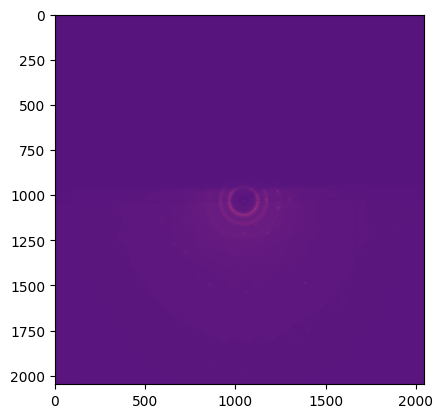

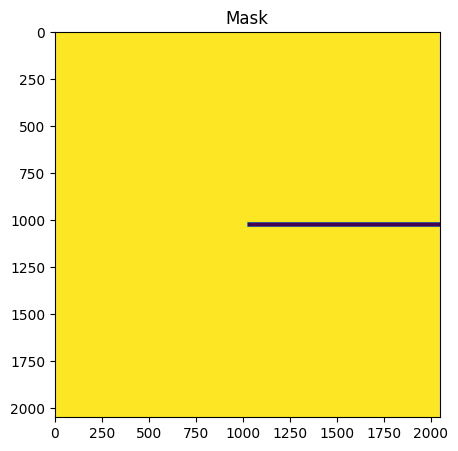

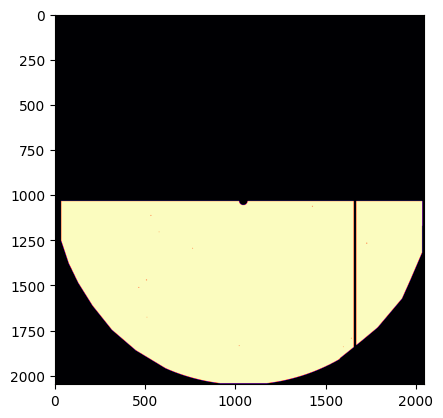

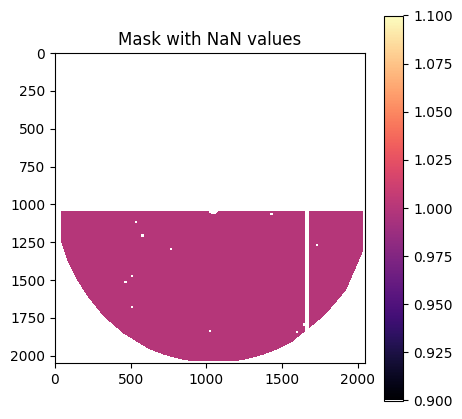

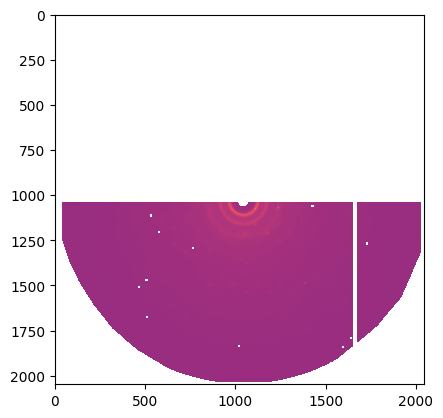

C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_16820\698494870.py:42: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(window)


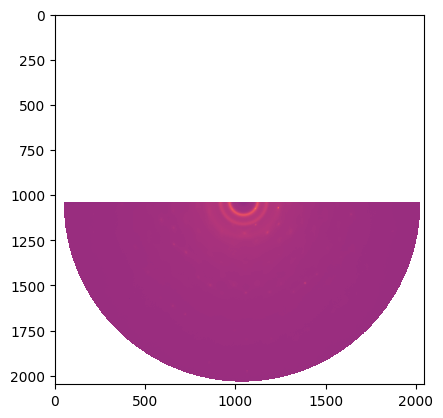

In [37]:
GST_6C_real_0035 = r'C:\Users\kelleymarisa\UFL Dropbox\Marisa Kelley\DNA&MDKShare\copy_data_isodat\p21p1\gits_a_GST_6C_real\gits_a_GST_6C_real_45_mdeg-00035.tif'
GST_6C_real_0035_image = imread(GST_6C_real_0035)
#check image
plt.imshow(GST_6C_real_0035_image, cmap = 'magma')
plt.show()
#create integration mask
mask_12 = create_mask_for_tiff(GST_6C_real_0035, 12)

#load image mask
gz_mask_path = r'C:\Users\kelleymarisa\UFL Dropbox\Marisa Kelley\DNA&MDKShare\copy_data_isodat\p21p1\Masks\mask_circle_edge_corrected.npy'
gz_mask = np.load(gz_mask_path)
# Invert the mask (0s become 1s and 1s become 0s)
gz_inverted_mask = 1 - gz_mask  # or: np.logical_not(mask_12).astype(float)
#check mask
plt.imshow(gz_inverted_mask, cmap = 'magma')
plt.show()

# turned zeros to NaN in invertedpyfai mask
# Convert zeros to NaN
gz_mask_with_nan = gz_inverted_mask.astype(float)  # Convert to float type first since NaN requires float
gz_mask_with_nan[gz_inverted_mask == 0] = np.nan
# Visualize to verify
plt.figure(figsize=(5, 5))
plt.imshow(gz_mask_with_nan, cmap='magma')
plt.title('Mask with NaN values')
plt.colorbar()
plt.show()

gz_combined_image = GST_6C_real_0035_image + gz_mask_with_nan
plt.imshow(gz_combined_image, cmap = 'magma')
plt.show()

gz_filled_with_mean = fill_nan_with_neighbor_mean_circle(gz_combined_image, radius = 992, center = (1048, 1035))
plt.imshow(gz_filled_with_mean, cmap = 'magma')
plt.show()

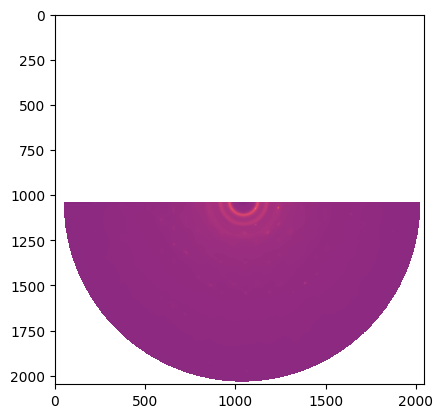

In [21]:
polarized_gz_image = apply_polarization(gz_filled_with_mean, 0.40008, center=None, polarization_factor=0.1)
#check image
plt.imshow(polarized_gz_image, cmap = 'magma')
plt.show()

Angle: 0.0°, Average Intensity: 6.25e+04
Center: (1048, 1035)


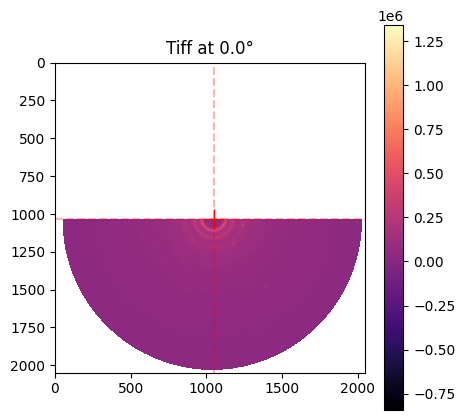

Angle: 50.0°, Average Intensity: 6.25e+04
Center: (1048, 1035)


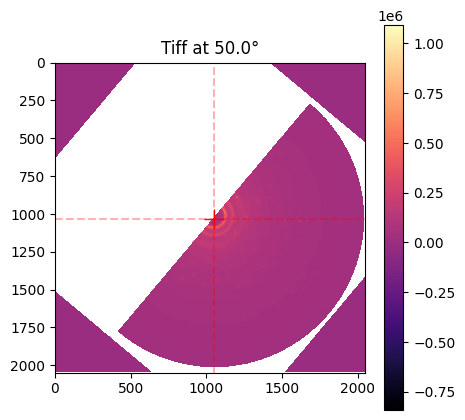

Angle: 100.0°, Average Intensity: 6.25e+04
Center: (1048, 1035)


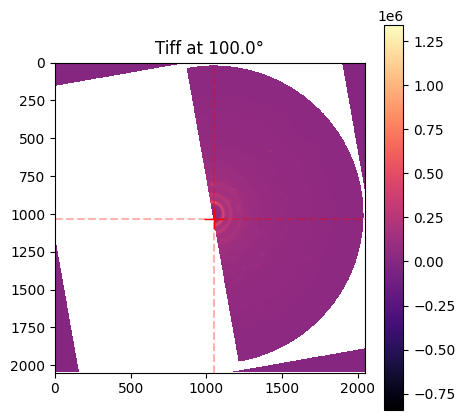

Angle: 150.0°, Average Intensity: 6.25e+04
Center: (1048, 1035)


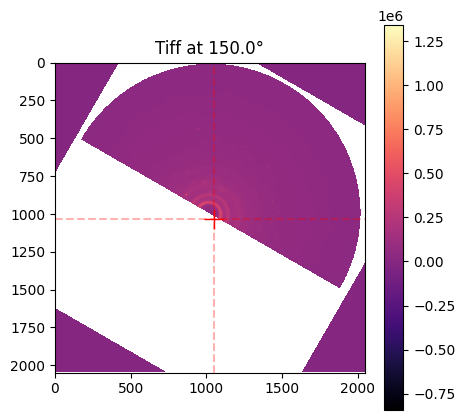

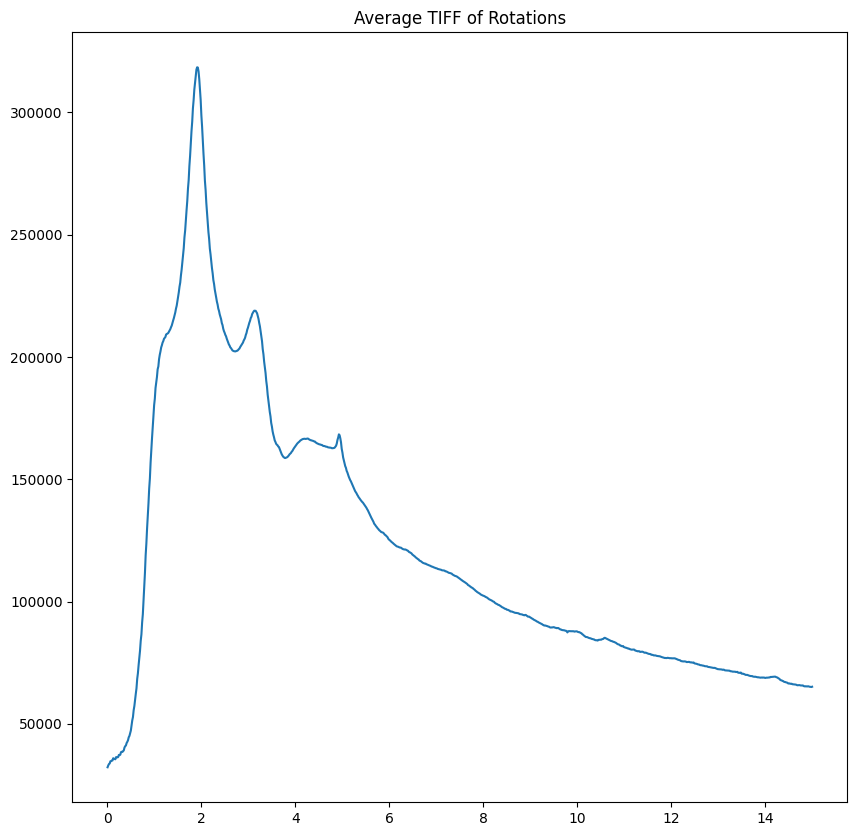

Original q range: [0.0075, 14.9925]
Normalized q range: [0.0000, 1.0000]

First few q values:
Original: [0.0075     0.0225     0.0375     0.05250001 0.06750001]
Normalized: [0.       0.001001 0.002002 0.003003 0.004004]


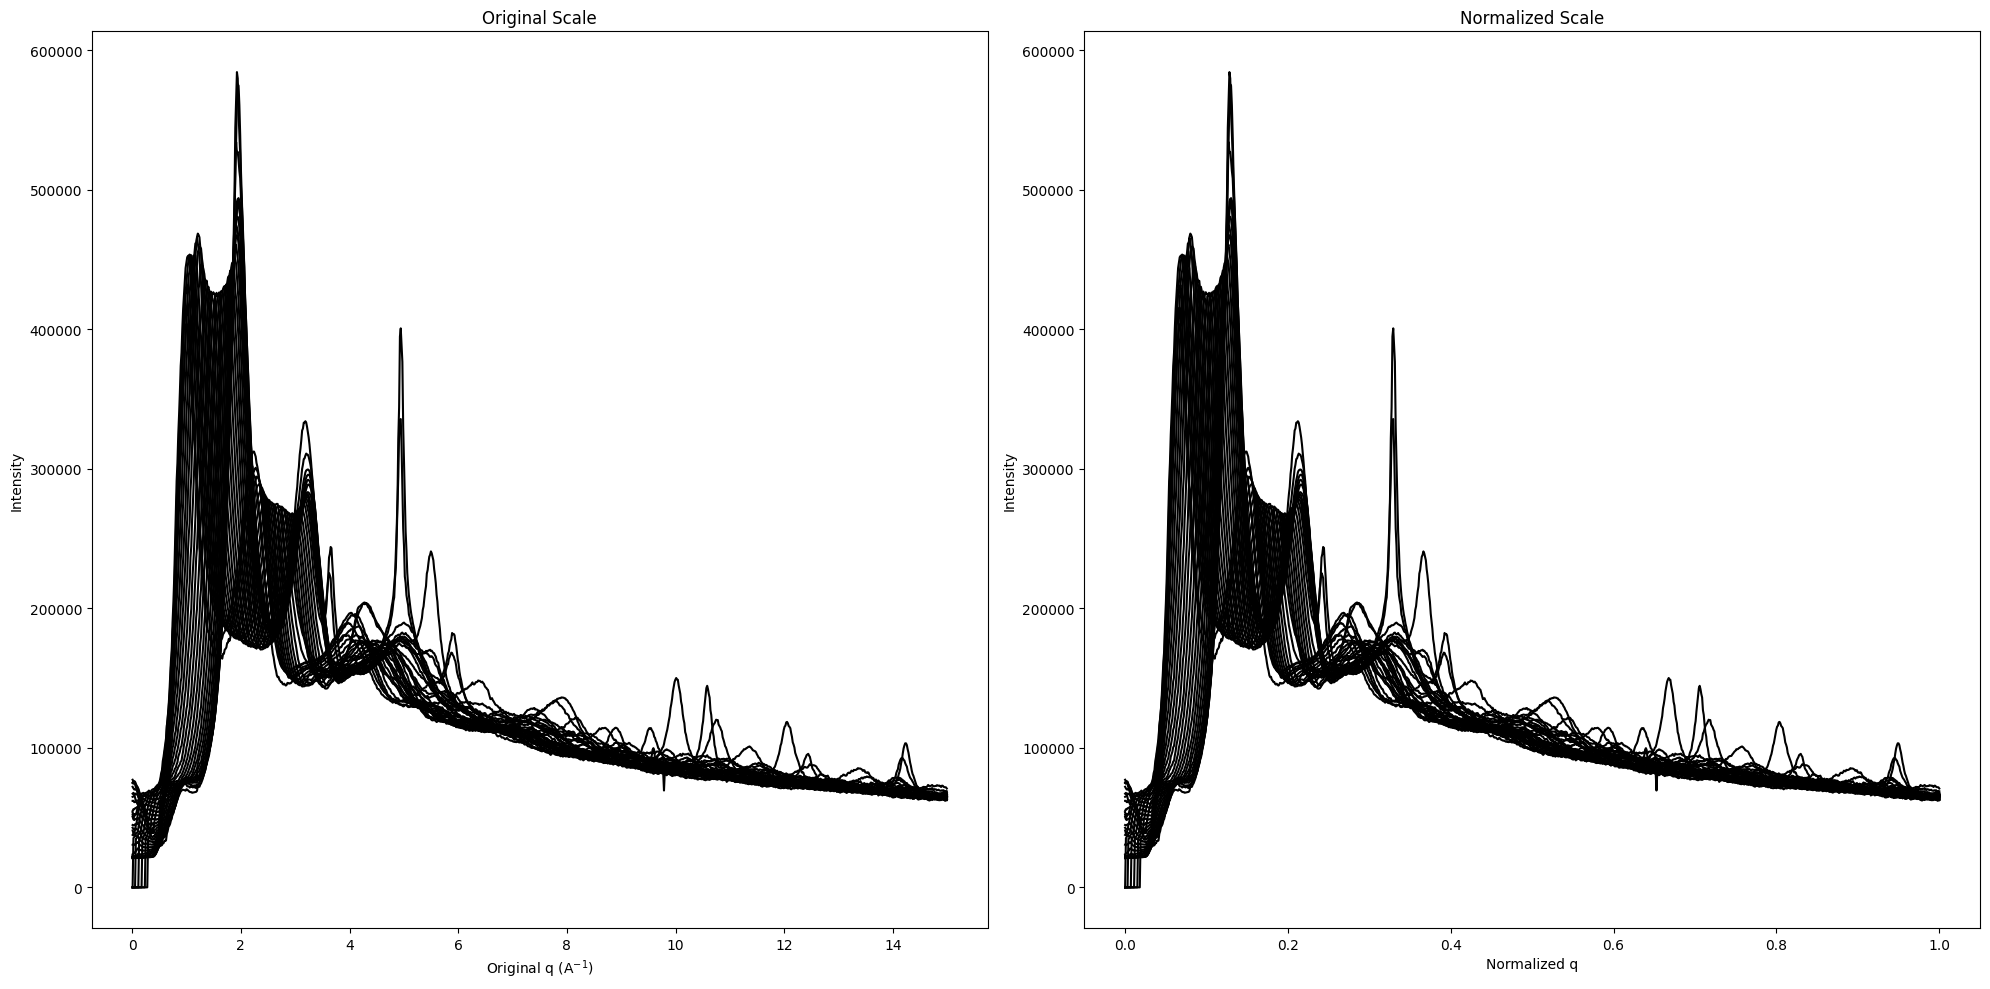

In [46]:
## Original rotate_and_integrate function with tiff rotation debug prints
# poni values applied
q, GST_6C_real_0035_nanmean_mask12, avg_tiff = rotate_and_integrate(polarized_gz_image, 5.0, .40008, 1.22212e-11, resolution = 1000, mask = mask_12, center = (1048, 1035))

compare to azimuthal

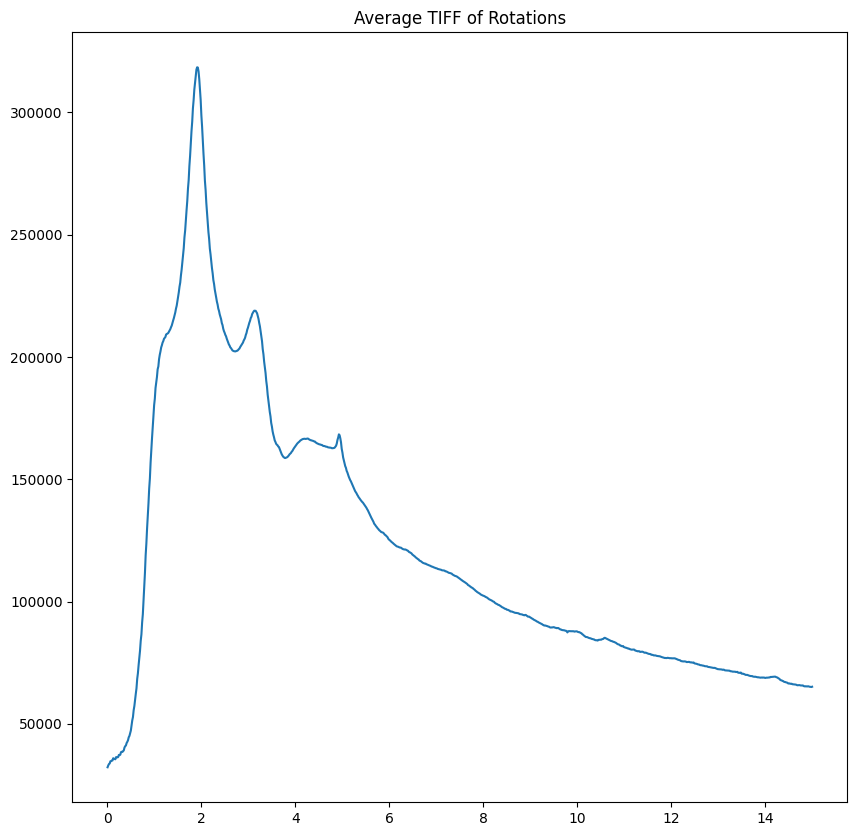

Available columns: ['q_A^-1', 'intensity']

First few rows of data:
     q_A^-1  intensity
0  0.583367   18587.61
1  0.606613   19665.52
2  0.629858   20318.97
3  0.653104   20709.86
4  0.676350   21831.48


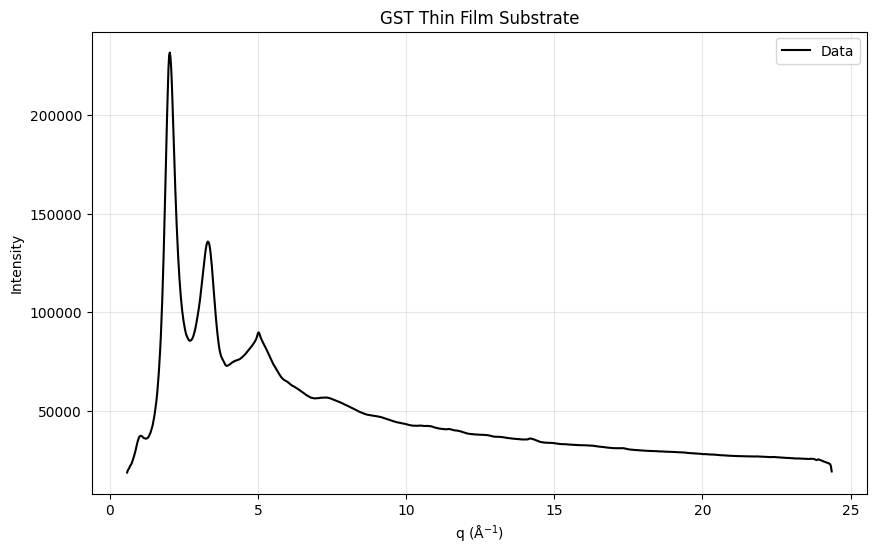

In [23]:
plt.figure(figsize=(10, 10))
plt.plot(q, avg_tiff)
plt.title("Average TIFF of Rotations")
plt.show()

# Load the azimuthal integration CSV file
man_azi_df = pd.read_csv('C:/Users/kelleymarisa/UFL Dropbox/Marisa Kelley/DNA&MDKShare/copy_data_isodat/isodat_data/GST_thinfilm_substrate_manualazi.csv', sep=';')

# Print column names to verify data
print("Available columns:", man_azi_df.columns.tolist())
print("\nFirst few rows of data:")
print(man_azi_df.head())
# Create plot
plt.figure(figsize=(10, 6))
plt.plot(man_azi_df['q_A^-1'], man_azi_df['intensity'], 'k-', label='Data')  # 'k-' means black line
# Customize plot
plt.xlabel('q (Å$^{-1}$)')
plt.ylabel('Intensity')
plt.title('GST Thin Film Substrate')
plt.grid(True, alpha=0.3)
plt.legend()
# Show plot
plt.show()

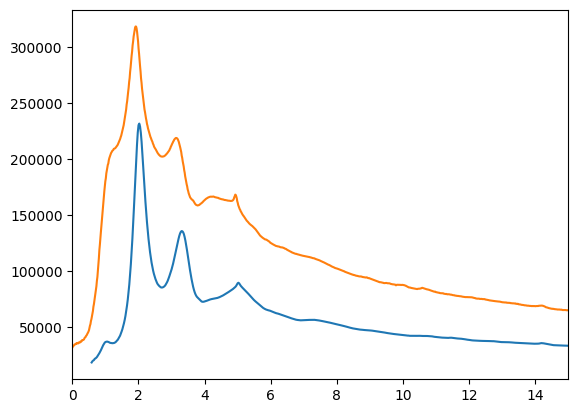

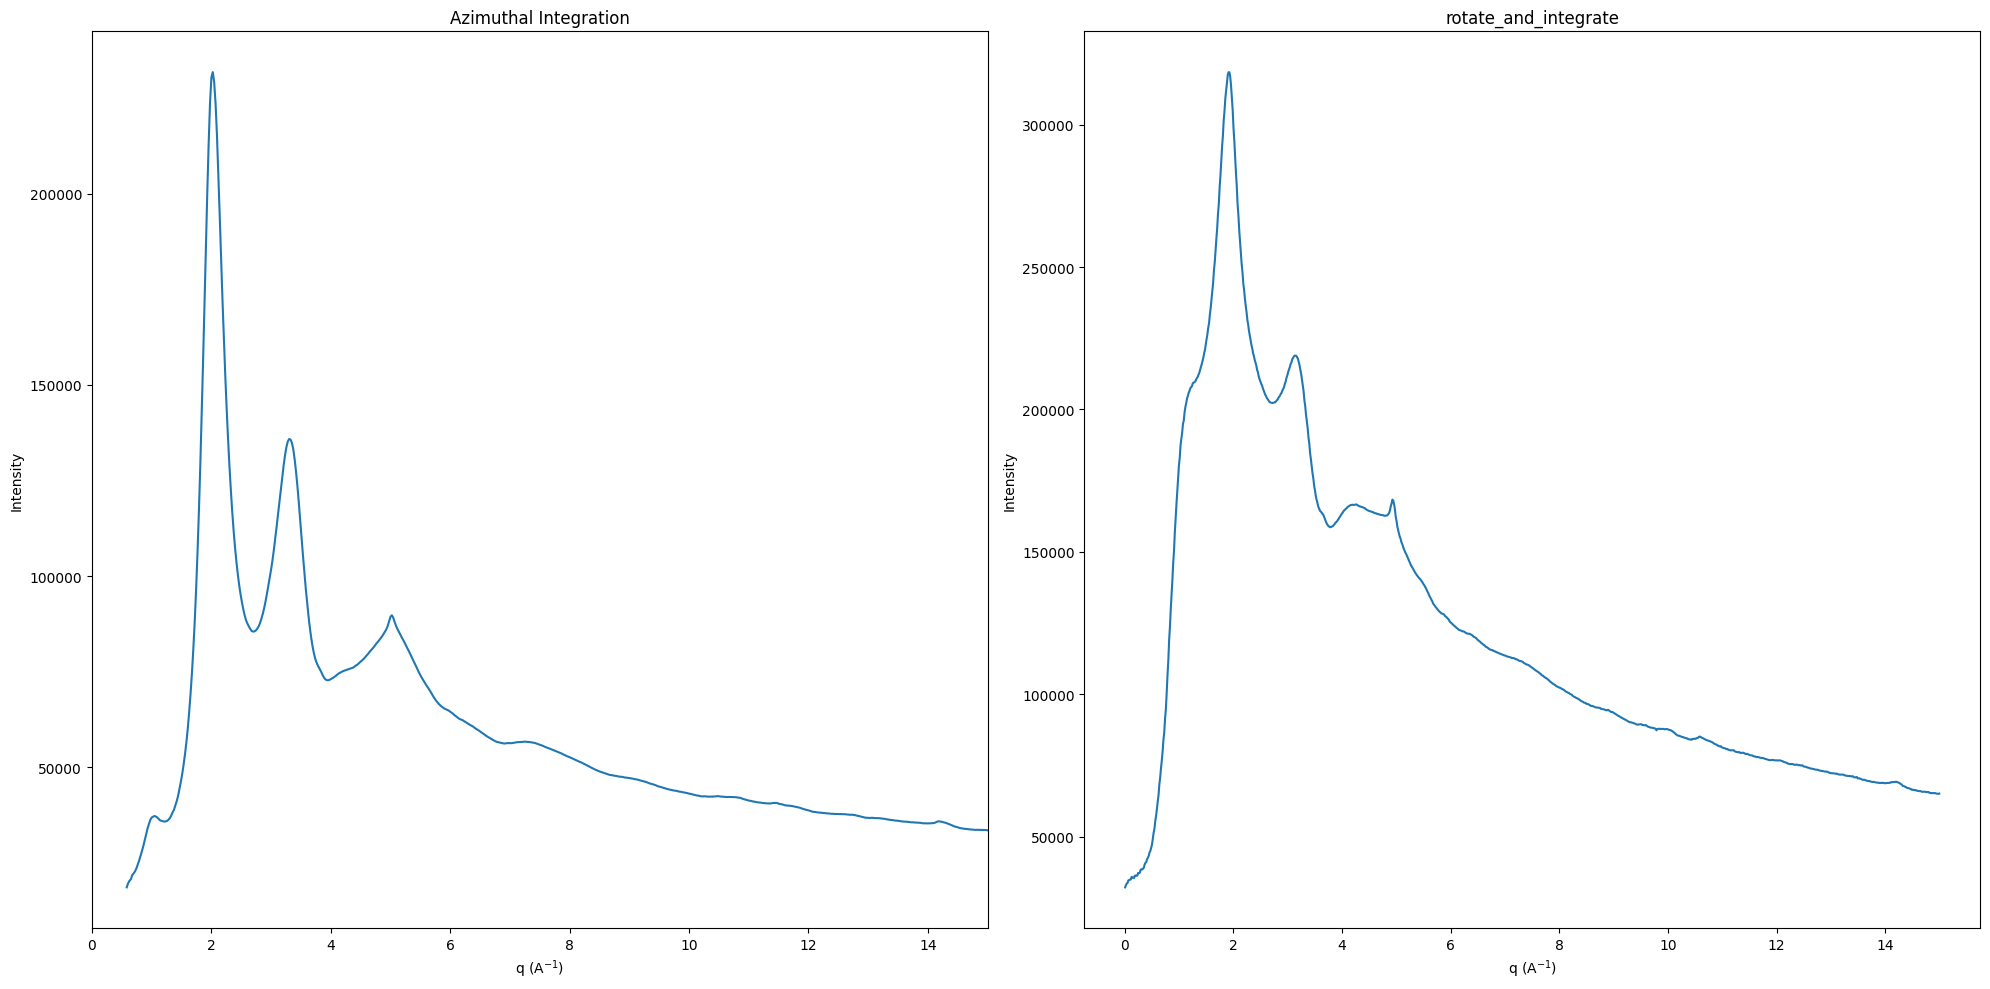

In [24]:
plt.plot(man_azi_df['q_A^-1'], man_azi_df['intensity'], label='Data')
plt.plot(q, avg_tiff, label='Data')
plt.xlim(0,15)
plt.show()

# Create DataFrame from avg_tiff data
avg_tiff_df = pd.DataFrame({
    'q': q,
    'intensity': avg_tiff})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(man_azi_df['q_A^-1'], man_azi_df['intensity'], label='Data')
ax1.set_xlabel('q (A$^{-1}$)')
ax1.set_xlim(0,15)
ax1.set_ylabel('Intensity')

ax1.set_title("Azimuthal Integration")

ax2.plot(avg_tiff_df['q'], avg_tiff_df['intensity'], label='Data')
ax2.set_xlabel('q (A$^{-1}$)')
ax2.set_ylabel('Intensity')
ax2.set_title("rotate_and_integrate") 

plt.tight_layout()
plt.show()


debugging rotation integration


--- Debugging angle: 1.0° ---
Original total intensity: 9.85e+10
Rotated total intensity: 9.85e+10
Difference: -0.00%


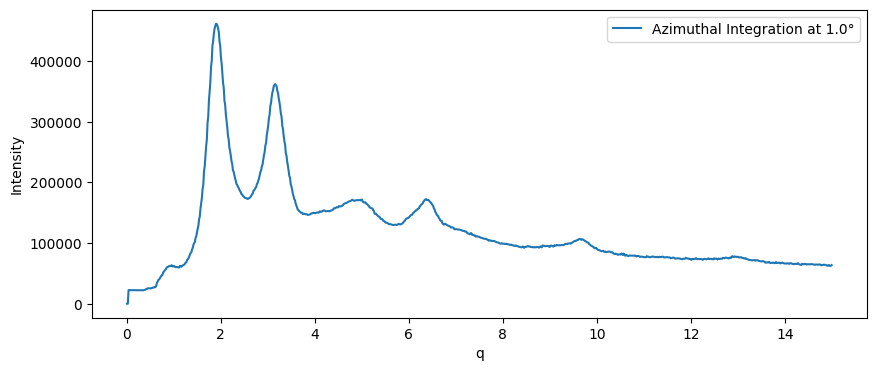

C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_16820\1304394529.py:10: RuntimeWarning: Mean of empty slice
  horizontal_integration = np.nanmean(image, axis=1)


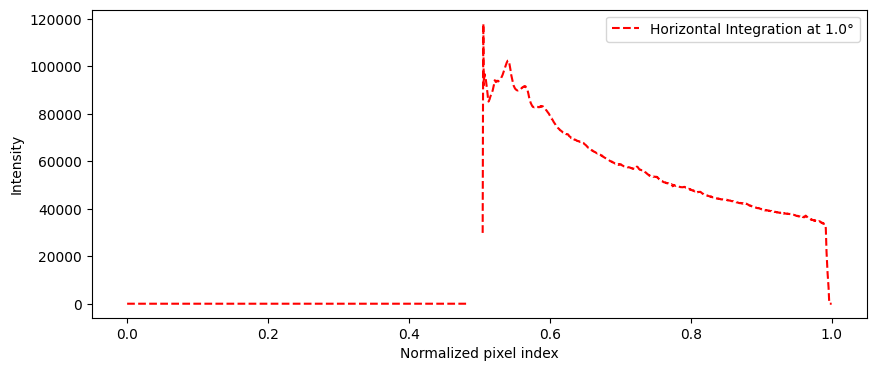


--- Debugging angle: 45.0° ---
Original total intensity: 9.85e+10
Rotated total intensity: 9.85e+10
Difference: 0.02%


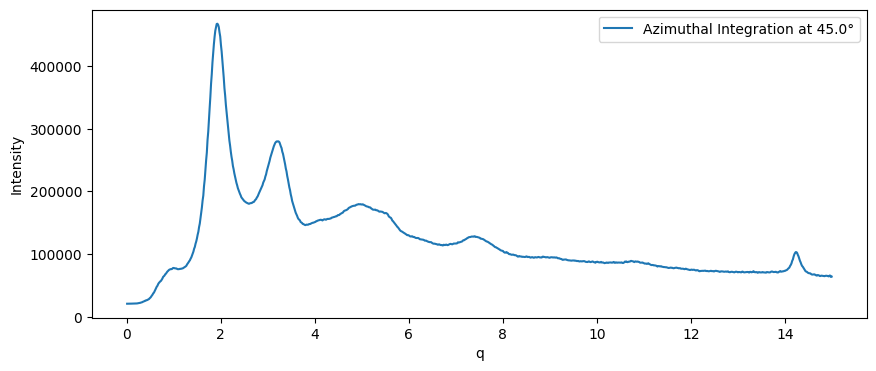

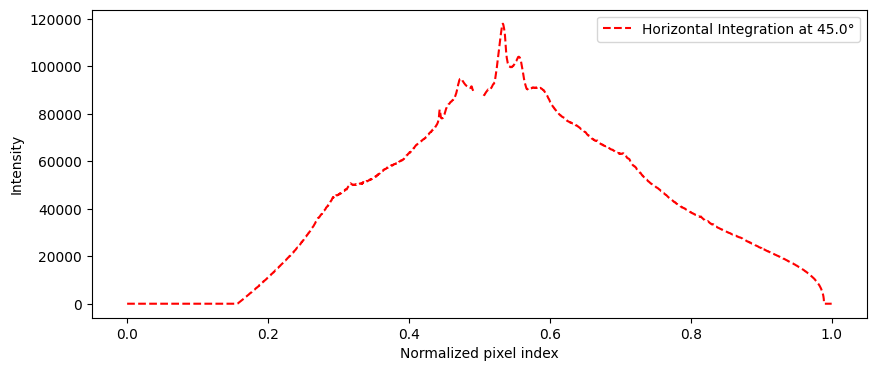


--- Debugging angle: 90.0° ---
Original total intensity: 9.85e+10
Rotated total intensity: 9.85e+10
Difference: 0.00%


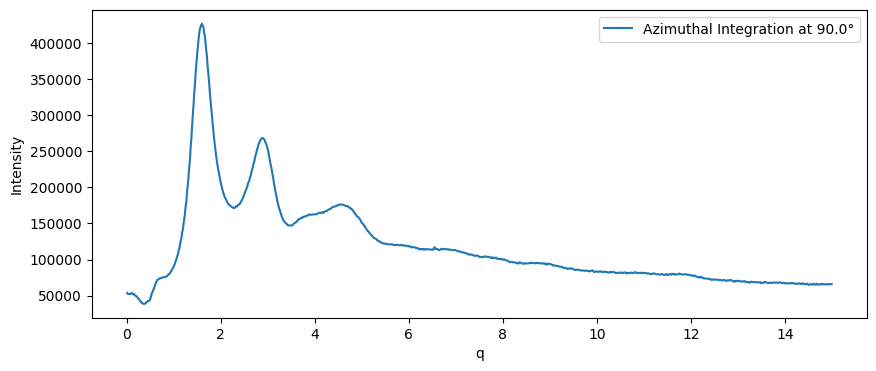

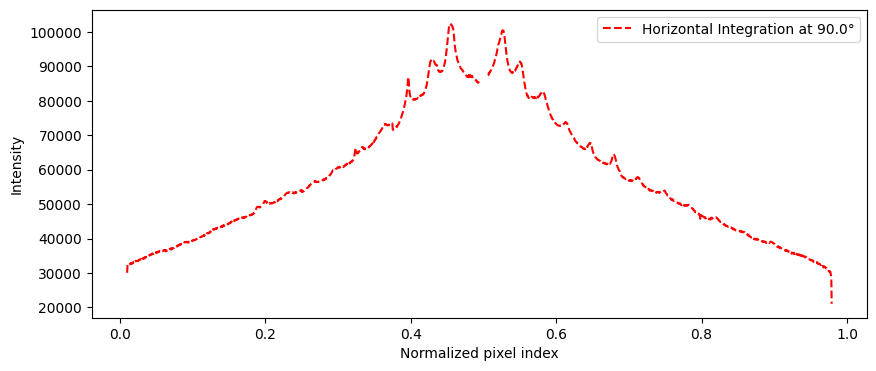


--- Debugging angle: 135.0° ---
Original total intensity: 9.85e+10
Rotated total intensity: 9.85e+10
Difference: 0.02%


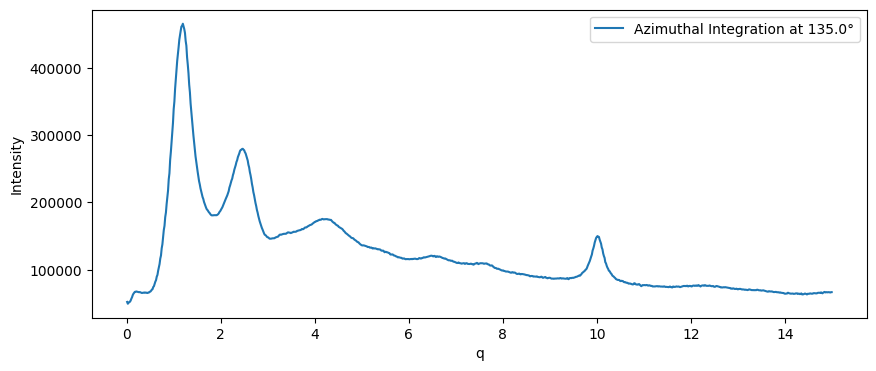

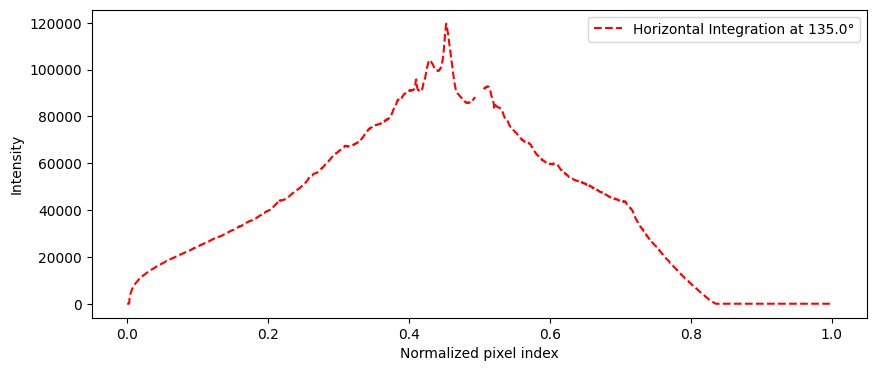


--- Debugging angle: 179.0° ---
Original total intensity: 9.85e+10
Rotated total intensity: 9.85e+10
Difference: -0.00%


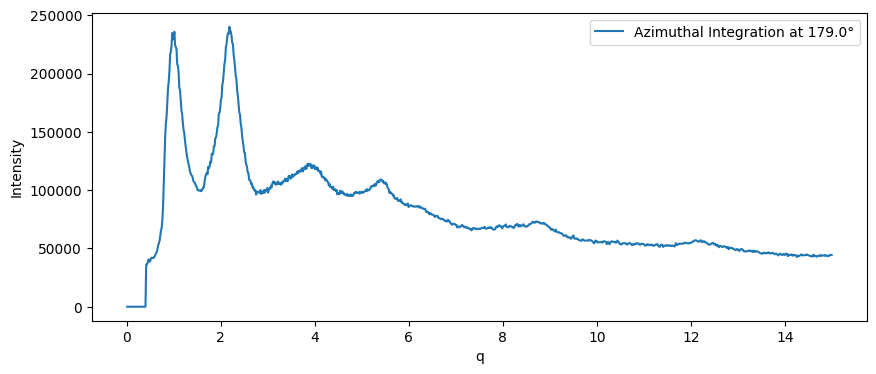

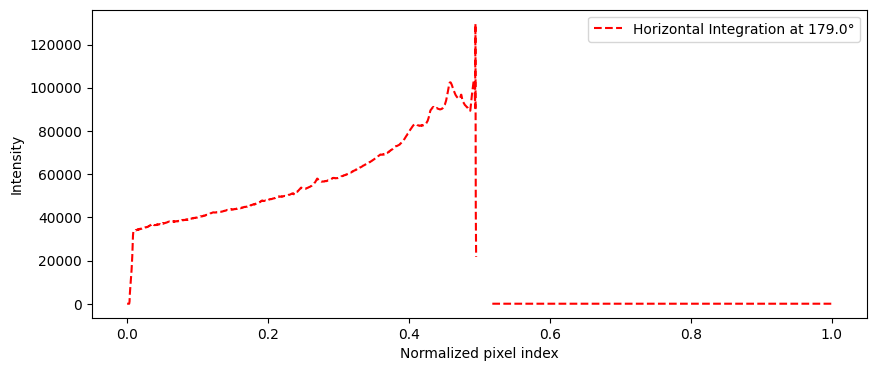

In [36]:
# --- 1. Debug Rotation Integration ---
# This function will loop over the specified angles. For each angle it will:
#   a) Print and plot the original vs. rotated image intensity totals.
#   b) Plot the azimuthal (radial) integration result.
#   c) Plot the horizontal integration result.
# Use these outputs to see whether the rotation is conserving intensity and how the integration curves compare.
debug_rotation_integration(
    image=polarized_gz_image,
    angles=[1, 45, 90, 135, 179],  # Pass specific angles to check
    distance=0.40008,
    wavelength=1.22212e-11,
    resolution=1000,
    mask=mask_12
)

binning method comparison

In [ ]:
# --- 2. Compare Binning Methods on the Original Image ---
# This function computes both the standard azimuthal integration (which bins by concentric rings) and a horizontal integration (which bins by rows), then plots them together.
# Differences between these curves indicate the effect of the binning scheme.
compare_binning_methods(polarized_gz_image, .40008, 1.22212e-11, resolution = 1000, mask = mask_12)